# Practicum 5: Supply II - Adding climate policies

We will now include climate policies more comprehensively (taxes and subsidies, but subsidies need to be paid by consumers).

The data and code are based on the paper "The Efficiency and Sectoral Distributional Implications of Large-Scale Renewable Policies," by Mar Reguant.

We first load relevant libraries, same as last session.

In [188]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyomo.environ import *

Remember to set your path correctly:

In [189]:
dirpath = "/Users/marreguant/Dropbox/TEACHING/BSE/Electricity2026/day5/practicum/"

## Building the model

We load the same data as last week, and also clean it up to simplify it further and create the demand and import curves. We annualize fixed costs for new plants.

In [190]:
TECHS = ["hydronuc","gas1","gas2","gas3","newgas","wind","solar"]
INV_TECHS = ["newgas","wind","solar"]
RES_TECHS = ["wind","solar"]

In [191]:
def load_and_prepare(dirpath: str):

    dfclust = pd.read_csv(f"{dirpath}/data_jaere_clustered.csv")
    tech = pd.read_csv(f"{dirpath}/data_technology.csv")

    # Re-scaling weights: multiply by 8.76 and normalize (so that we can interpret it as annual revenue in million USD)
    dfclust["weights"] = 8.76 * dfclust["weights"] / dfclust["weights"].sum()

    # One demand type (sum of components)
    dfclust["demand"] = (
        dfclust["q_residential"] + dfclust["q_commercial"] + dfclust["q_industrial"]
    )

    # Calibrate demand curve: demand = a - b * price
    elas = np.array([0.1, 0.2, 0.5, 0.3])
    dfclust["b"] = elas[2] * dfclust["demand"] / dfclust["price"]
    dfclust["b"] = dfclust["b"].mean()  # constant slope across t
    dfclust["a"] = dfclust["demand"] + dfclust["b"] * dfclust["price"]

    # Calibrate imports: imports = am + bm * price
    dfclust["bm"] = elas[3] * dfclust["imports"] / dfclust["price"]
    dfclust["am"] = dfclust["imports"] - dfclust["bm"] * dfclust["price"]

    # Set index names for tech
    tech.index = TECHS
    
        # Annualization factor and fixed costs
    afactor = (1 - (1 / (1.05**20.0))) / 0.05
    tech["F"]  = tech["F"]  / afactor

    return dfclust, tech

dfclust, tech = load_and_prepare(dirpath)

In [192]:
tech

,techname,heatrate,heatrate2,F,capLB,capUB,new,renewable,solar,thermal,e,e2,c,c2
hydronuc,Hydro/Nuclear,10.000000,0.000000,0.000000,1.000,1.000,0,0,0,0,0.000000,0.000000,10.000000,0.000000
gas1,Existing 1,6.671990,0.092912,0.000000,7.500,11.500,0,0,0,1,0.360184,0.004886,23.351965,0.325193
gas2,Existing 2,9.794118,0.286247,0.000000,10.500,14.500,0,0,0,1,0.546134,0.011078,34.279413,1.001866
gas3,Existing 3,13.818120,20.535160,0.000000,0.578,0.578,0,0,0,1,0.816768,0.234476,48.363420,71.873060
newgas,New Gas,6.600000,0.000000,78.477250,0.000,100.000,1,0,0,1,0.350000,0.000000,23.351965,0.325193
wind,Wind,0.000000,0.000000,100.303234,0.000,100.000,1,1,0,0,0.000000,0.000000,0.000000,0.000000
solar,Solar,0.000000,0.000000,100.303234,0.000,100.000,1,1,1,0,0.000000,0.000000,0.000000,0.000000


## Adding taxes and subsides to the problem

We modify our mixed integer code with an additional renewable subsidy and renewable charge that consumers need to pay.

In [244]:
def clear_market_invest(data, tech, ng_price=3.5, tax=0.0, subsidy=0.0, renewable_charge=0.0,
            scc=100.0, Kmax=50.0, solver_name="ipopt"):
    """
    Welfare max with endogenous investment (NLP)
    """
    T = len(data)

    # plain python lookups (no Params)
    c = {k: float(tech.at[k, "c"]) for k in TECHS}
    if "heatrate" in tech.columns:
        for k in ["gas1","gas2","gas3","newgas"]:
            if k in tech.index:
                c[k] = float(tech.at[k, "heatrate"]) * float(ng_price)

    e = {k: float(tech.at[k, "e"]) for k in TECHS} if "e" in tech.columns else {k: 0.0 for k in TECHS}
    F = {k: float(tech.at[k, "F"]) for k in TECHS} if "F" in tech.columns else {k: 0.0 for k in TECHS}
    capUB = {k: float(tech.at[k, "capUB"]) for k in ["gas1","gas2","gas3"] if "capUB" in tech.columns and k in tech.index}

    m = ConcreteModel()
    m.T = RangeSet(0, T-1)
    m.I = Set(initialize=TECHS, ordered=False)
    m.J = Set(initialize=INV_TECHS, ordered=False)

    m.price   = Var(m.T, domain=Reals)
    m.demand  = Var(m.T, domain=Reals)
    m.imports = Var(m.T, domain=Reals)

    m.q     = Var(m.T, m.I, domain=NonNegativeReals)
    m.costs = Var(m.T, domain=Reals)
    m.gs    = Var(m.T, domain=Reals)

    m.K      = Var(m.J, bounds=(0.0, float(Kmax)))  # capacity investments

    # Objective: gross surplus - variable costs - fixed costs
    m.obj = Objective(
        expr=sum(data.weights[t] * (m.gs[t] - m.costs[t]) for t in m.T)
             - sum(F.get(k) * m.K[k] for k in m.J),
        sense=maximize
    )

    # Market clearing
    m.demand_curve  = Constraint(m.T, expr={t: m.demand[t]  == data.a[t]  - data.b[t] * renewable_charge -  data.b[t]  * m.price[t] for t in m.T})
    m.imports_curve = Constraint(m.T, expr={t: m.imports[t] == data.am[t] + data.bm[t] * m.price[t] for t in m.T})
    m.market_clear  = Constraint(m.T, expr={t: m.demand[t]  == sum(m.q[t,k] for k in m.I) + m.imports[t] for t in m.T})

    # Surplus + costs
    m.surplus_def = Constraint(
        m.T,
        expr={t: m.gs[t] == (data.a[t] - data.b[t] * renewable_charge - m.demand[t]) * m.demand[t] / data.b[t] + (m.demand[t]**2) / (2.0 * data.b[t])
              for t in m.T}
    )
    m.cost_def = Constraint(
        m.T,
        expr={t: m.costs[t] == sum((c[k] + float(tax) * e[k] - subsidy * tech.at[k, "renewable"]) * m.q[t,k] for k in m.I)
                           + (m.imports[t] - data.am[t])**2 / (2.0 * data.bm[t])
              for t in m.T}
    )

    # Capacity constraints
    m.cap_hydronuc = Constraint(m.T, expr={t: m.q[t,"hydronuc"] <= data.hydronuc[t] for t in m.T})
    if capUB:
        m.cap_gas123 = Constraint(m.T, Set(initialize=list(capUB)),
                                  expr={(t,k): m.q[t,k] <= capUB[k] for t in m.T for k in capUB})

    m.cap_newgas = Constraint(m.T, expr={t: m.q[t,"newgas"] <= m.K["newgas"] for t in m.T})
    m.cap_wind   = Constraint(m.T, expr={t: m.q[t,"wind"]   <= m.K["wind"]  * data.wind_cap[t]  for t in m.T})
    m.cap_solar  = Constraint(m.T, expr={t: m.q[t,"solar"]  <= m.K["solar"] * data.solar_cap[t] for t in m.T})

    res = SolverFactory(solver_name).solve(m, tee=False)
    term = str(res.solver.termination_condition)

    if term.lower() in ("optimal", "locallyoptimal", "locally_optimal", "locally optimal"):
        price   = np.array([value(m.price[t])   for t in m.T])
        demand  = np.array([value(m.demand[t])  for t in m.T])
        imports = np.array([value(m.imports[t]) for t in m.T])
        q = {k: np.array([value(m.q[t,k]) for t in m.T]) for k in TECHS}
        K = {k: float(value(m.K[k]))           for k in INV_TECHS}

        w_arr = data["weights"].to_numpy()
        avg_price = float(np.sum(price * w_arr) / np.sum(w_arr))

        objective = float(np.sum([data.weights[t] * (value(m.gs[t]) - value(m.costs[t])) for t in m.T])
                        - F.get("newgas", 0.0) * K["newgas"]
                        - F.get("wind",   0.0) * K["wind"]
                        - F.get("solar",  0.0) * K["solar"])
        
        w_arr = data["weights"].to_numpy()
        emissions = sum(w_arr[t] * sum(e[i] * q[i][t] for i in m.I) for t in m.T)
        subsidy_cost = subsidy * sum(w_arr[t] * sum(q[k][t] for k in RES_TECHS) for t in m.T)
        needed_charge = subsidy_cost / np.sum(w_arr * demand)
        wind_curtailment = 1.0 - (
            np.sum(w_arr * (q["wind"] / (K["wind"] + 1e-4))) /
            np.sum(w_arr * data.wind_cap)
            )
        solar_curtailment = 1.0 - (
            np.sum(w_arr * (q["solar"] / (K["solar"] + 1e-4))) /
            np.sum(w_arr * data.solar_cap)
        )
        avg_price = float(np.sum(price * w_arr)/np.sum(w_arr))

        # we add terms that affect welfare but not the optimization objective
        welfare = objective - subsidy_cost + tax * emissions - scc * emissions

        # cost accounting (same as Julia 'cost' line: gen + import quad; no tax term there)
        gen_cost_t = np.array([value(m.costs[t])   for t in m.T])
        imp_cost_t = (imports - data["am"].to_numpy()) ** 2 / (2.0 * data["bm"].to_numpy())
        total_cost = float(np.sum(w_arr * (gen_cost_t + imp_cost_t)))

        return {"status": term, "avg_price": avg_price, "price": price, "quantity": q, "imports": imports,
                "demand": demand, "cost": total_cost, "objective": objective, "welfare": welfare, "K": K,
                "emissions": emissions, "subsidy_cost": subsidy_cost, "needed_charge": needed_charge,
                "wind_curtailment": wind_curtailment, "solar_curtailment": solar_curtailment}

    return {"status": term}


In [245]:
results = clear_market_invest(dfclust, tech, ng_price=3.5, subsidy=15.0)

In [246]:
results["K"]

{'newgas': -9.973565121165228e-09,
 'wind': 42.56617420184121,
 'solar': -9.970627164696308e-09}

In [247]:
print(f"Average price: {results['avg_price']:.2f} and Welfare: {results['welfare']:.2f}")

Average price: 23.27 and Welfare: 7920.74


In [248]:
results_nosubsidy = clear_market_invest(dfclust, tech, ng_price=3.5)

In [249]:
results_nosubsidy["K"]

{'newgas': 1.7241707468488838,
 'wind': -8.611376876105954e-09,
 'solar': -9.935480557561231e-09}

In [250]:
print(f"Average price: {results_nosubsidy['avg_price']:.2f} and Welfare: {results_nosubsidy['welfare']:.2f}")

Average price: 31.93 and Welfare: 5750.94


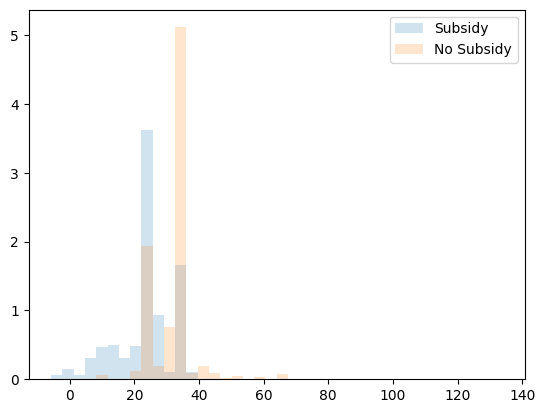

In [251]:
# We see much lower wholesale prices with the subsidy
p1 = np.asarray(results["price"])
p2 = np.asarray(results_nosubsidy["price"])

# common bins (choose a number you like)
bins = np.histogram_bin_edges(np.concatenate([p1, p2]), bins=40)

plt.figure()
plt.hist(p1, bins=bins, weights=dfclust.weights, alpha=0.2, label="Subsidy")
plt.hist(p2, bins=bins, weights=dfclust.weights, alpha=0.2, label="No Subsidy")
plt.legend()
plt.show()

In [253]:
# Comparison to tax = SCC
results_scc = clear_market_invest(dfclust, tech, ng_price=3.5, tax=100.0)
print(f"Average price: {results_scc['avg_price']:.2f} and Welfare: {results_scc['welfare']:.2f}")

Average price: 40.61 and Welfare: 9502.95


## How to pay for the subsidies? Computing the renewable charge

We would like to add a constraint that states that the subsidies given to firms (solar and wind) need to equal the payments made by consumers with the renewable charges.

Let's compare the needed charge to zero (our default charge).


In [254]:
print(f"Needed charge: {results['needed_charge']:.4f}")

Needed charge: 6.3974



One computational issue is that this is what is called a non-linear equation (`demand` and `renewable_charge` multiply each other, making it harder to compute).

It is best to proceed with a search approach for the renewable charge. We will code it with a simple loop here (akin to the visual search we saw last week for entry).

We get intuition first without making it a function.

In [255]:
current_diff = 1.0
guess = results["needed_charge"]
max_iter = 10
it = 0

while current_diff > 1e-4 and it < max_iter:
    res = clear_market_invest(dfclust, tech, renewable_charge=guess, subsidy=15.0)
    newguess = res["needed_charge"]
    current_diff = (guess - newguess) ** 2
    print(f"Iter {it}: guess={guess:.4f}, newguess={newguess:.4f}, diff={current_diff:.6f}")
    guess = newguess
    it += 1

print(f"Final guess: {guess:.4f}")

Iter 0: guess=6.3974, newguess=5.9459, diff=0.203811
Iter 1: guess=5.9459, newguess=5.9780, diff=0.001028
Iter 2: guess=5.9780, newguess=5.9757, diff=0.000005
Final guess: 5.9757


The result is telling the equilibrium renewable charge.

### Making it into a function

We create a function that will do the loop and return the optimal solution.

In [256]:
def clear_market_equilibrium(data, tech, ng_price=3.5, tax=0.0, subsidy=0.0,
                             tol=1e-3, max_iter=10):
    current_diff = 1.0
    guess = subsidy / 3.0
    it = 0

    while current_diff > tol and it < max_iter:
        res = clear_market_invest(
            data, tech,
            ng_price=ng_price, tax=tax, subsidy=subsidy, renewable_charge=guess
        )

        if res["status"] == "optimal":
            newguess = res["needed_charge"]
        else:
            print(f"Model is {res['status']} at {guess}")
            return res

        current_diff = (guess - newguess) ** 2
        guess = newguess
        it += 1

    # solve at (approx) equilibrium to return results
    res = clear_market_invest(
        data, tech,
        ng_price=ng_price, tax=tax, subsidy=subsidy, renewable_charge=guess
    )
    return res

In [257]:
res_eq = clear_market_equilibrium(dfclust,tech,subsidy=15.0,ng_price=3.5)

In [288]:
print(res_eq["needed_charge"])

5.975844037798281


In [258]:
res_eq

{'status': 'optimal',
 'avg_price': 22.93072072206046,
 'price': array([ 34.27941299,  23.351965  ,  23.351965  ,  26.82353479,
         23.351965  ,  23.351965  ,  21.34299979,  34.279413  ,
         23.351965  ,  23.35196499,  10.11420505,  34.279413  ,
         23.351965  ,  23.351965  ,  32.98197595,  34.279413  ,
         23.35196501,  17.30720996,  34.27941299,  10.00000011,
         22.70359001,   7.23005387,  23.35196498,  23.351965  ,
         23.35196501,  23.351965  ,  23.35196504,  23.351965  ,
         34.279413  ,  24.28913988,  18.40595929,  26.60664629,
         32.13551974,  34.24713583,  34.279413  ,  23.351965  ,
         23.48813839,  34.279413  ,  23.351965  ,  23.35196502,
         23.351965  ,  -5.09425405,   1.24194072,  14.84921632,
         34.27941298,  23.351965  ,  23.351965  ,  10.        ,
         36.52188957,  24.45060816,  34.279413  ,  23.35196502,
         23.351965  ,  23.351965  ,  34.27941266,  13.13695081,
         32.93923574,  13.20599839,  23.

A subsidy of $15/MWh gets about 36.5 GW of installed new wind and average prices around $23/MWh.

What is an equivalent tax? How does it impact emissions and prices?

In [268]:
results_tax = clear_market_invest(dfclust, tech, ng_price=3.5, tax=140.0)

In [269]:
results_tax["K"]

{'newgas': -9.836185395680548e-09,
 'wind': 36.553109680273536,
 'solar': -9.838701112281703e-09}

In [270]:
print(f"Emissions with tax: {results_tax['emissions']:.2f} vs subsidy: {res_eq['emissions']:.2f}")

Emissions with tax: 0.81 vs subsidy: 23.83


In [271]:
print(f"Prices with tax vs subsidy: {results_tax['avg_price']:.2f} vs {res_eq['avg_price']:.2f}")

Prices with tax vs subsidy: 41.33 vs 22.93


In [272]:
w=dfclust.weights
print(f"Welfare with tax vs subsidy: {results_tax['welfare']:.2f} vs {res_eq['welfare']:.2f}")

Welfare with tax vs subsidy: 9463.55 vs 6804.59


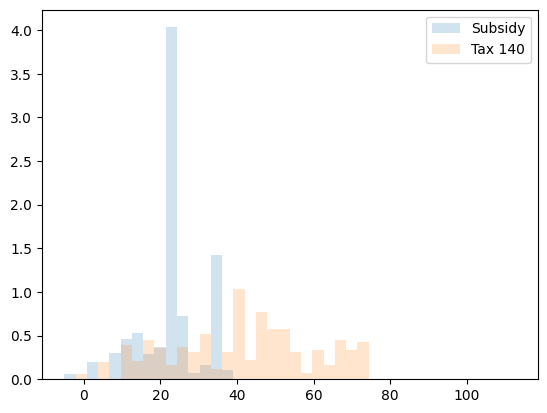

In [274]:
# Prices are *very* different
p1 = np.asarray(res_eq["price"])
p2 = np.asarray(results_tax["price"])

# common bins (choose a number you like)
bins = np.histogram_bin_edges(np.concatenate([p1, p2]), bins=40)

plt.figure()
plt.hist(p1, bins=bins, weights=dfclust.weights, alpha=0.2, label="Subsidy")
plt.hist(p2, bins=bins, weights=dfclust.weights, alpha=0.2, label="Tax 140")
plt.legend()
plt.show()

## Follow-up questions

1. What are the costs of reaching a certain emissions target with subsidies vs. with taxes? You can solve this by using another loop that targets the right level of tax/subsidy.
   
2. What about adding three sectors (residential, commercial, industrial)? How do results change depending on which sector pays for the subsidies?
   
3. How could you add a Renewable Portfolio Standard or a Clean Energy Standard? Remember you need to search for the parameter that leads to a certain renewable share (RPS) or emissions rate (CES). This is the target in the loop.
   
4. How could we make the model better to account for higher level notions of welfare?